# 糖尿病視網膜前處理

In [8]:
import torch
from sympy.physics.quantum.gate import normalized

from config import config
from dataloader import get_dataloader

# Load Dataset
train_dataloader, test_dataloader = get_dataloader(
    # dataset='PreprocessedRetinaMNIST224',
    dataset='RetinaMNIST_224',
    root=config['root'] + '/data/',
    batch_size=config['batch_size'],
    input_size=(224,224)
)

images, labels = torch.tensor([]), torch.tensor([])
for batch in test_dataloader:
    imgs, lbls = batch
    images = torch.cat((images, imgs))
    labels = torch.cat((labels, lbls))
print(images.shape, labels.shape)

<class 'dataloader.CustomerMedMNIST.CustomerRetinaMNIST_224'>
Using downloaded and verified file: C:\Users\Cobra\.medmnist\retinamnist_224.npz
Using downloaded and verified file: C:\Users\Cobra\.medmnist\retinamnist_224.npz
torch.Size([400, 3, 224, 224]) torch.Size([400, 5])


In [9]:
images[0].shape

torch.Size([3, 224, 224])

In [29]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt


def display_image_comparison(save_path=None, **images_dict):
    """
    顯示多張圖片的比較，使用變數名稱作為標題
    Args:
        save_path: 圖片保存路徑，如果提供則保存圖片
        **images_dict: 圖片變數，例如 original=img1, enhanced=img2 等
    """
    image_list = list(images_dict.values())
    title_list = list(images_dict.keys())
    num_images = len(image_list)

    fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 6))

    for idx in range(num_images):
        img = image_list[idx]

        # 將 PyTorch tensor 轉換為 numpy 並調整通道
        if torch.is_tensor(img):
            if img.shape[0] == 1:  # 灰階圖片
                img = img.squeeze(0).cpu().numpy()
            else:  # RGB 圖片
                img = img.permute(1, 2, 0).cpu().numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)

        # 使用 cmap='gray' 顯示灰階圖片
        if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
            axes[idx].imshow(img, cmap='gray')
        else:
            axes[idx].imshow(img)
            
        axes[idx].set_title(title_list[idx])
        axes[idx].axis('off')

    plt.tight_layout()
    
    # 如果提供保存路徑，則保存圖片
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

def preprocess_retinal_tensor_image(image_tensor, target_radius=224):
    """
    Retina 圖像的預處理，保留為 PyTorch tensor 格式 (CxHxW)

    Args:
        image_tensor: 輸入圖像 tensor (CxHxW)
        target_radius: 縮放後圖像的半徑基準大小

    Returns:
        Tuple of processed tensors: (scaled, blurred, contrast_enhanced, final_output)
    """
    if not isinstance(image_tensor, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    device = image_tensor.device
    is_cuda = image_tensor.is_cuda

    # CxHxW → HxWxC → numpy array
    img_np = image_tensor.permute(1, 2, 0).detach().cpu().numpy()
    if img_np.dtype != np.uint8:
        img_np = (img_np * 255).clip(0, 255).astype(np.uint8)

    # Step 1: 根據亮度估計半徑並縮放
    row_brightness = img_np[img_np.shape[0] // 2, :, :].sum(axis=1)
    estimated_radius = (row_brightness > row_brightness.mean() / 10).sum() / 2
    scale_factor = target_radius / estimated_radius
    scaled_img = cv2.resize(img_np, (0, 0), fx=scale_factor, fy=scale_factor)

    # Step 2: 高斯模糊
    blurred_img = cv2.GaussianBlur(scaled_img, (0, 0), target_radius / 30)

    # Step 3: 增強對比
    sub_blurred_img = cv2.addWeighted(scaled_img, 4, blurred_img, -4, 0)
    contrast_img = cv2.addWeighted(scaled_img, 4, blurred_img, -4, 128)

    # Step 4: 遮罩處理（中心圓形區域保留）
    mask = np.zeros_like(scaled_img, dtype=np.uint8)
    center = (scaled_img.shape[1] // 2, scaled_img.shape[0] // 2)
    radius = int(target_radius * 0.9)
    cv2.circle(mask, center, radius, (1, 1, 1), thickness=-1)
    final_img = contrast_img * mask + 128 * (1 - mask)

    def to_tensor(np_img):
        tensor = torch.tensor(np_img, dtype=torch.float32).permute(2, 0, 1) / 255.0
        return tensor.to(device)

    return (
        to_tensor(scaled_img),
        to_tensor(blurred_img),
        to_tensor(sub_blurred_img),
        to_tensor(contrast_img),
        to_tensor(final_img)
    )

tensor([0., 1., 0., 0., 0.])


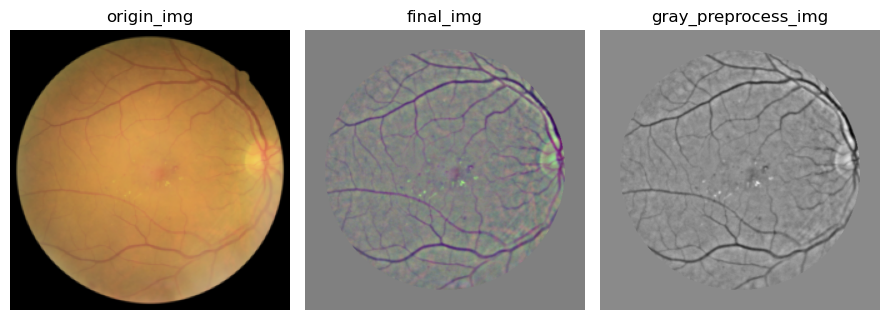

tensor([0., 0., 0., 1., 0.])


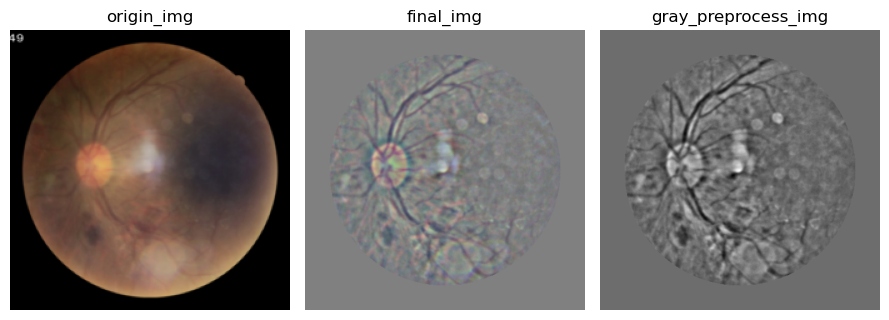

tensor([0., 0., 0., 0., 1.])


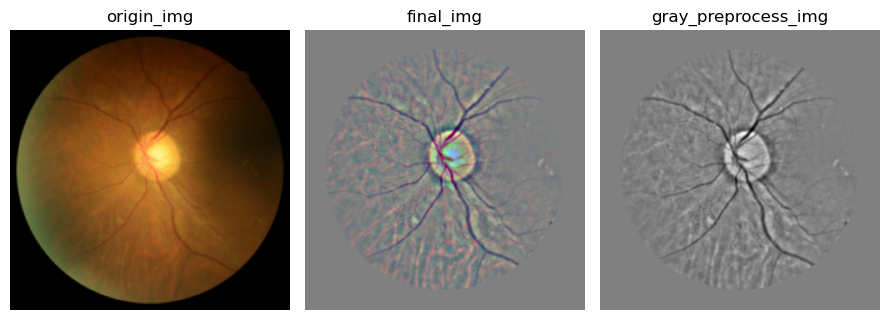

tensor([0., 0., 1., 0., 0.])


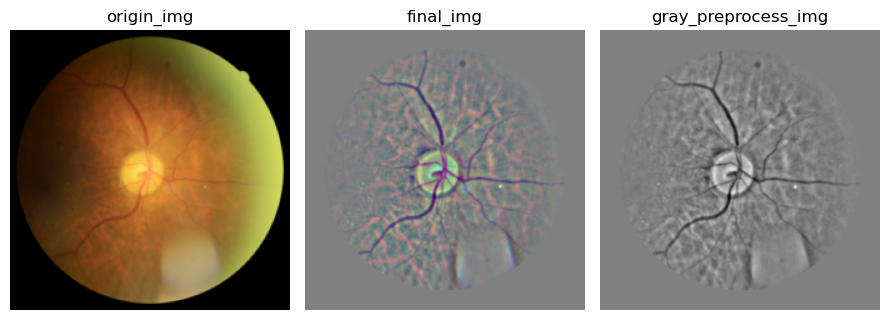

tensor([1., 0., 0., 0., 0.])


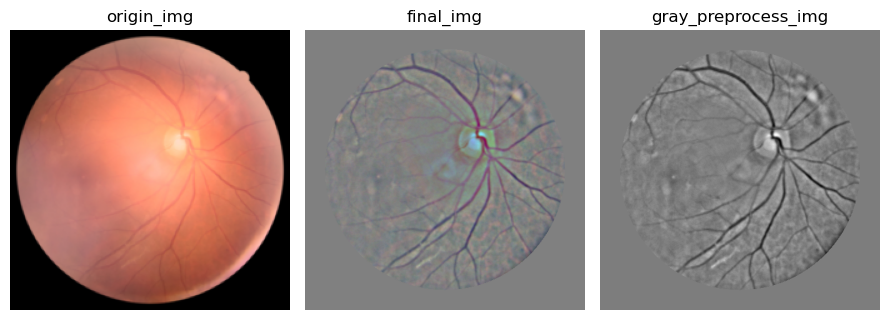

tensor([0., 1., 0., 0., 0.])


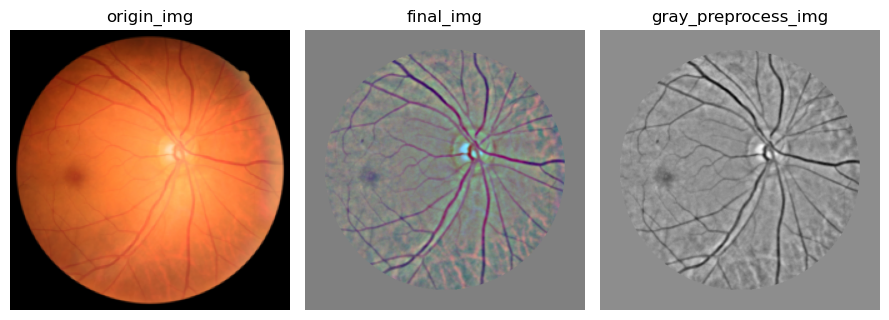

tensor([1., 0., 0., 0., 0.])


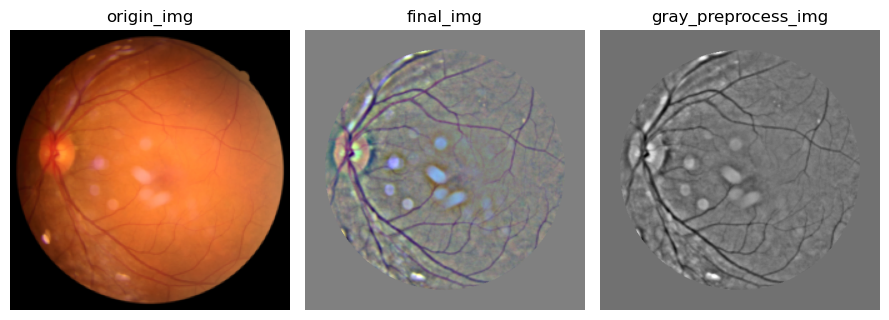

tensor([1., 0., 0., 0., 0.])


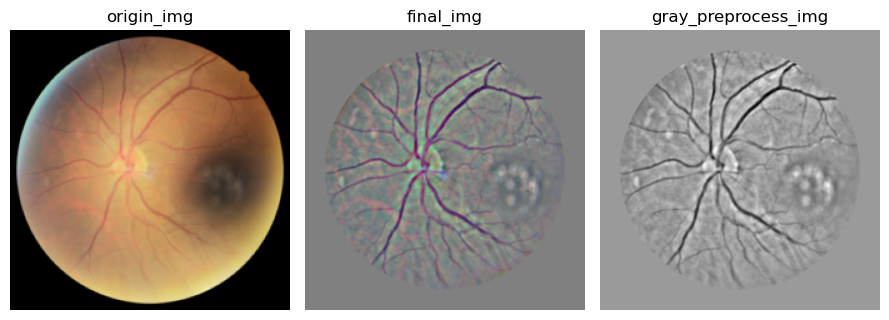

tensor([1., 0., 0., 0., 0.])


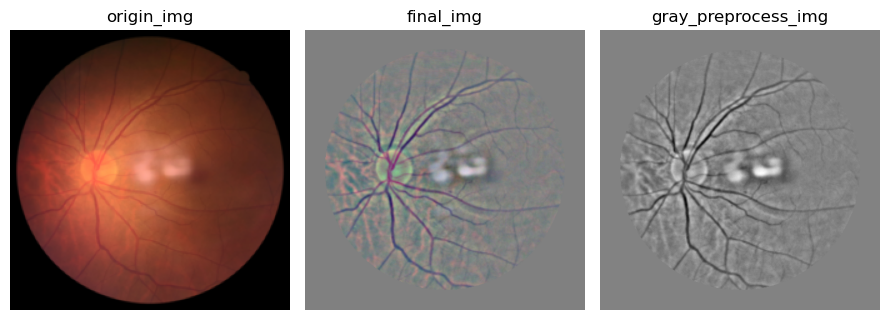

tensor([0., 0., 1., 0., 0.])


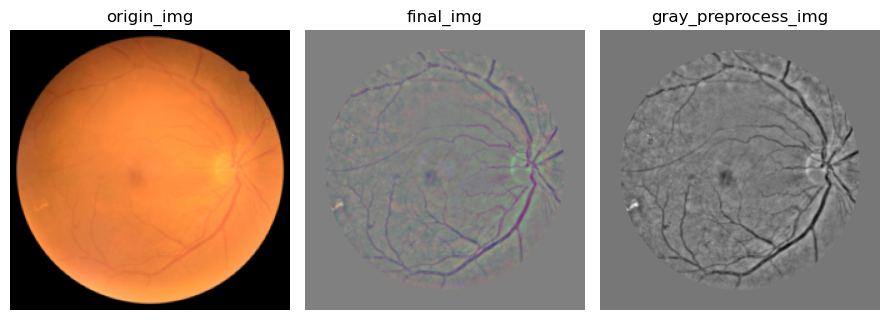

tensor([0., 0., 1., 0., 0.])


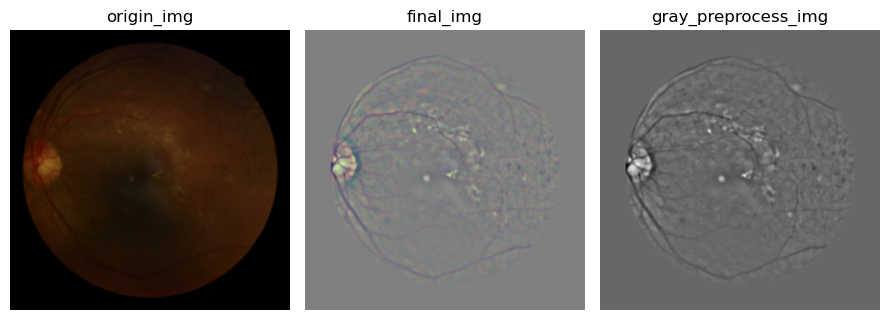

tensor([1., 0., 0., 0., 0.])


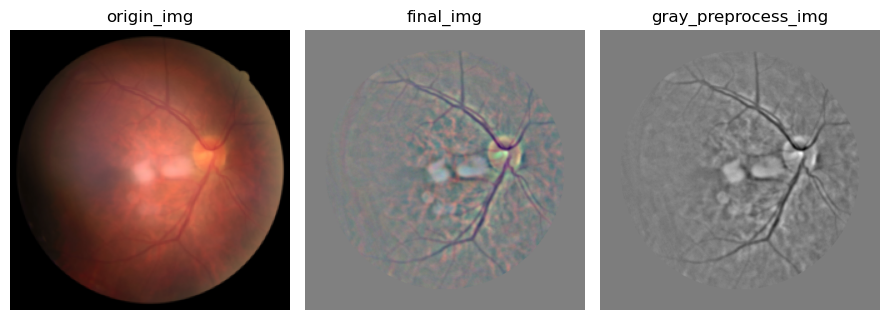

tensor([0., 0., 0., 1., 0.])


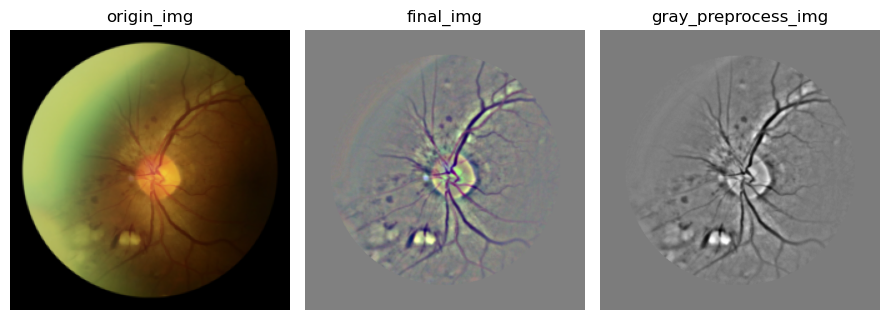

tensor([0., 0., 0., 1., 0.])


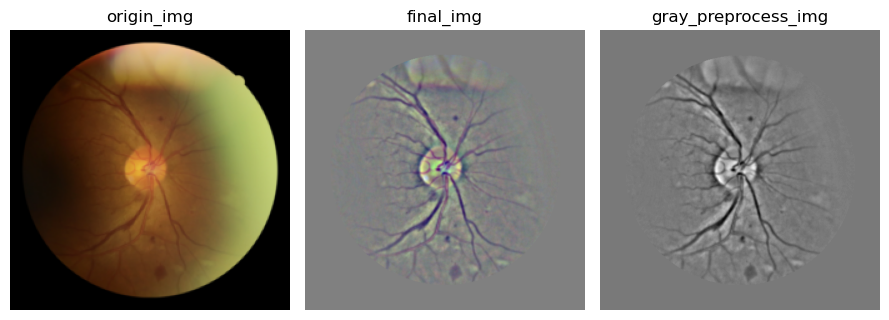

tensor([1., 0., 0., 0., 0.])


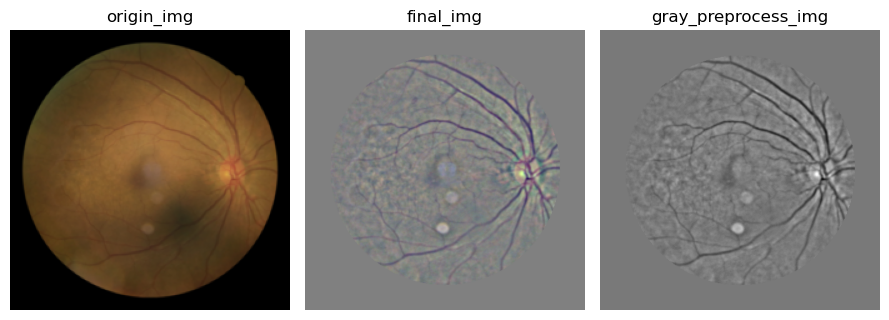

tensor([1., 0., 0., 0., 0.])


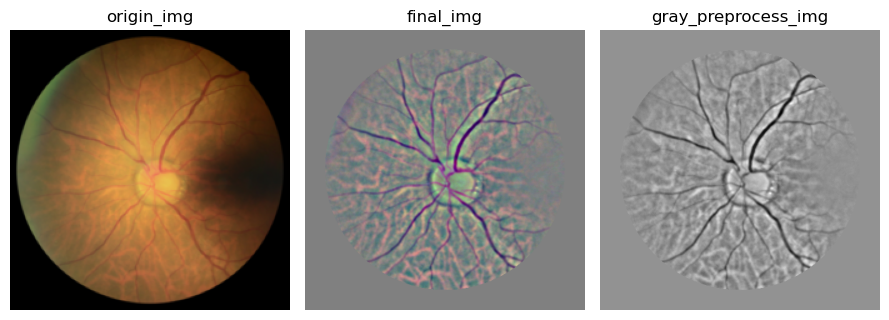

tensor([1., 0., 0., 0., 0.])


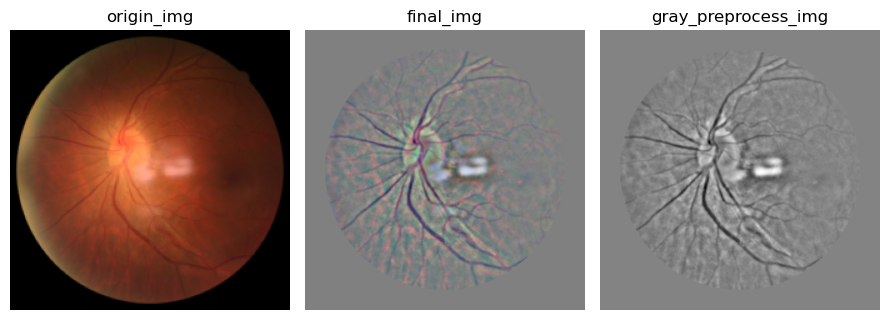

tensor([0., 0., 1., 0., 0.])


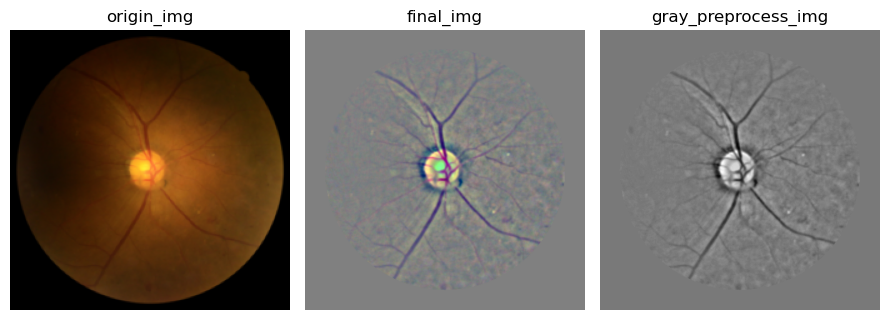

tensor([1., 0., 0., 0., 0.])


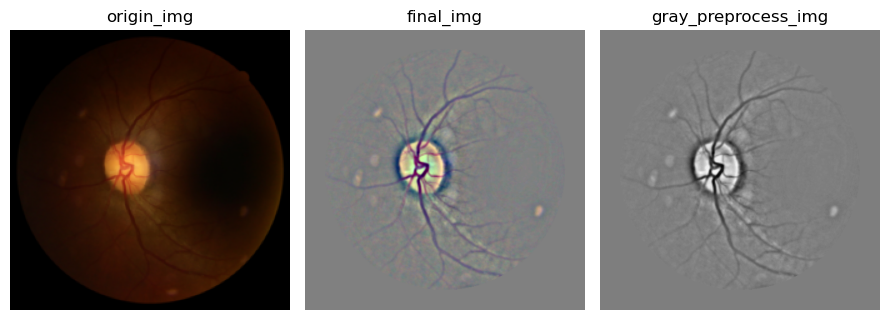

tensor([1., 0., 0., 0., 0.])


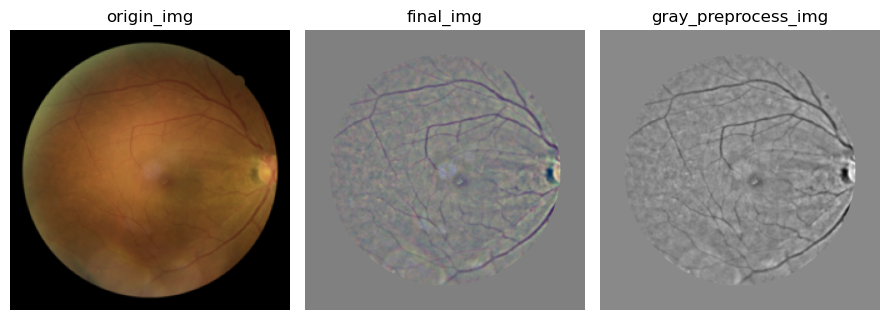

In [31]:
from models.RGB_SFMCNN_V2 import NormalizeToRange
import torchvision

# 新的調用方式：

gray_transform = torchvision.transforms.Compose([
        torchvision.transforms.Grayscale(),
        # Sobel_Conv2d(),
        # Renormalize(),
        # NormalizeToRange(),
    ])

for i in range(20, 40):
    print(labels[i]) 
    origin_img = images[i]
    scaled_img, blurred_img, sub_blurred_img, high_contrast_img, final_img = preprocess_retinal_tensor_image(origin_img)
    # display_image_comparison(origin_img = origin_img, scaled_img = scaled_img, blurred_img = blurred_img, 
    #                 high_contrast_img = high_contrast_img, final_img = final_img)

    gray_preprocess_img = gray_transform(final_img.unsqueeze(0))[0]  # 使用模型中的灰階轉換
    # gray_img = gray_transform(origin_img.unsqueeze(0))[0]  # 使用模型中的灰階轉換
    
    # 完整圖
    # display_image_comparison(origin_img = origin_img, blurred_img =blurred_img,  
    #                          sub_blurred_img = sub_blurred_img,high_contrast_img =high_contrast_img, final_img = final_img, gray_preprocess_img=gray_preprocess_img)
    display_image_comparison(origin_img = origin_img, final_img = final_img, gray_preprocess_img=gray_preprocess_img)


